In [35]:
import numpy as np
import matplotlib.pyplot as plt
import commpy as cp
from scipy import interpolate

### Seleccione el modo que va a usar, asignando 1,2 o 3 a la variable "modo". En esta simulacion se considera que los unicos esquemas de modulacion utilizados son los sincronicos (QPSK,16QAM y 64QAM) y que solo se utilizara una capa jerarquica para la transmision

In [108]:
BW=6*(10**6)
modo=1
L=1404*(2**(modo-1))+1 #Portadoras SP,CP,TMCC,AC1,AC2,Datos
Ls=int((L-1)/13)
Lsinf=12*(2**(modo-1)) #Portadoras SP,CP,TMCC,AC1,AC2 en cada segmento
Lspil=int(Lsinf*3/4)    #Portadoras SP,
Lsdat=Ls-Lsinf     #Portadoras datos

Para el posterior analisis se ignoraran las portadoras TMCC, AC1,AC2 ya que si se las considera deben introducirse en funcion de tablas aleatorias y no seria practico introducirlas a mano debido a su extension. Luego...

In [109]:
Lspil=Lsinf

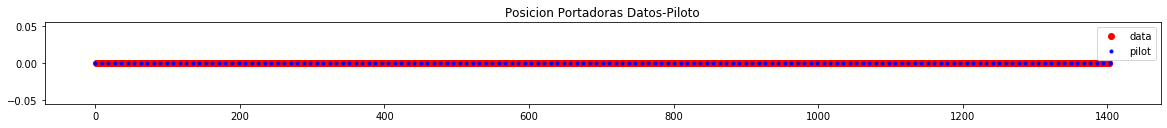

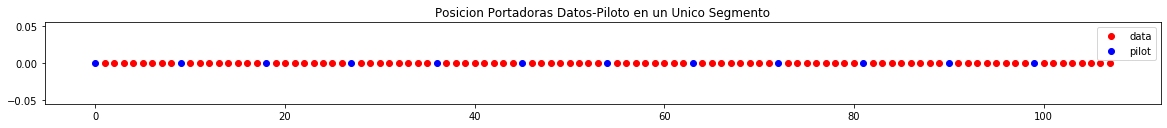

In [110]:
carriersActivas=np.arange(L)
carriersPiloto=carriersActivas[::int((L-1)/(Lspil*13))] #Multiplico por 13 para el numero de pilotos total. La
                                                        #separacion entre pilotos sera de 12
carriersPiloto = np.hstack([carriersPiloto, np.array([carriersActivas[-1]])]) #La ultima es CP pero como solo 
                                                                             #considero SP se la asigno a este grupo
carriersDatos = np.delete(carriersActivas, carriersPiloto)

plt.figure(figsize=(20,1.5))
plt.title("Posicion Portadoras Datos-Piloto")
plt.plot(carriersDatos, np.zeros_like(carriersDatos), 'ro', label='data')
plt.plot(carriersPiloto, np.zeros_like(carriersPiloto), 'b.', label='pilot')
plt.legend(fontsize=10)

plt.figure(figsize=(20,1.5))
plt.title("Posicion Portadoras Datos-Piloto en un Unico Segmento")
plt.plot(carriersDatos[:Lsdat], np.zeros_like(carriersDatos[:Lsdat]), 'ro', label='data')
plt.plot(carriersPiloto[:Lspil], np.zeros_like(carriersPiloto[:Lspil]), 'bo', label='pilot')
plt.legend(fontsize=10)

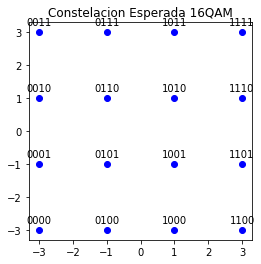

In [111]:
mu = 4 # bits per symbol (i.e. 16QAM)
bits_OFDMsimbolo= len(carriersActivas)*mu  #Numero de bits transportados en un simbolo OFDM
bits_Data_OFDMsimbolo= len(carriersDatos)*mu  #Numero de bits de datos transportados en un simbolo OFDM

qamObj = cp.modulation.QAMModem(2**mu) #Creates a Quadrature Amplitude Modulation (QAM) Modem object.
                                   #m (int) – Size of the QAM constellation.

#ARMO UNA CONSTELACION GENERICA
lista=[]
plt.figure(figsize=(4,4))
plt.title("Constelacion Esperada 16QAM")
for b3 in [0, 1]:
    for b2 in [0, 1]:
        for b1 in [0, 1]:
            for b0 in [0, 1]:
                #lista.append(b5)
                #lista.append(b4)
                lista.append(b3)
                lista.append(b2)
                lista.append(b1)
                lista.append(b0)
                #B=np.asarray((b5,b4,b3,b2,b1,b0))
                B=np.asarray((b3,b2,b1,b0))
                Q=qamObj.modulate(B)
                plt.plot(Q.real, Q.imag, 'bo')
                plt.text(Q.real, Q.imag+0.2, "".join(str(x) for x in B), ha='center')
                #El +0.2 es para que la palabra no quede arriba del punto y se vea bien
lista=np.asarray(lista)
constelacion=qamObj.modulate(lista)#modulate(input_bits) 	Modulate (map) an array of bits to constellation symbols.

In [112]:
bits = np.random.binomial(n=1, p=0.5, size=(bits_Data_OFDMsimbolo, )) #A los otros les asignare valores conocidos
print ("N° de bits: ", len(bits))
print ("Primeros 20 bits: ", bits[:20])
print ("Media: ", np.mean(bits))

N° de bits:  4992
Primeros 20 bits:  [1 0 0 0 0 1 0 0 1 0 1 0 1 1 0 0 1 0 1 1]
Media:  0.49038461538461536


In [113]:
QAM = qamObj.modulate(bits)#modulate(input_bits) 	Modulate (map) an array of bits to constellation symbols.
print ("Primeros 5 QAM simbolos:")
print (QAM[:5])

Primeros 5 QAM simbolos:
[ 1.-3.j -1.-3.j  1.+1.j  3.-3.j  1.+3.j]


In [114]:
pilotValue = (1+1j)*(((2**mu))**0.5-1) # Valor conocido que se asignara a las portadoras
print("El valor de mis portadoras piloto sera:",pilotValue)

Lifft=2**(10+modo) #Portadoras activas + nulas
Lnull=Lifft-L

def OFDM_symbol(QAM_payload):
    symbol = np.zeros(Lifft, dtype=complex) # Creo el espacio para asignar todas las portadoras
    symbol[::]=0
    symbol[carriersPiloto+Lnull//2] = pilotValue
    symbol[carriersDatos+Lnull//2] = QAM_payload
    #Lo hice de esa forma ya que voy a considererar las portadoras nulas que se distribuyen equitativamente a los costados
    return symbol

OFDM_data = OFDM_symbol(QAM)

El valor de mis portadoras piloto sera: (3+3j)


In [115]:
carriersTotales=np.arange(Lifft)

Numero de muestras OFDM en el dominio del tiempo antes del intervalo de guarda:  2048


/home/supremequeen/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


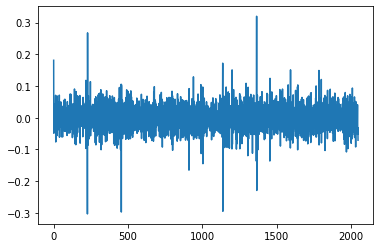

In [116]:
def IDFT(OFDM_data):
    return np.fft.ifft(OFDM_data)
OFDM_time = IDFT(OFDM_data)
print ("Numero de muestras OFDM en el dominio del tiempo antes del intervalo de guarda: ", len(OFDM_time))
plt.plot(OFDM_time)

In [117]:
CP=Lifft//4

def addCP(OFDM_time):
    cp = OFDM_time[-CP:]               #Tomo las ultimas muestras
    return np.hstack([cp, OFDM_time])  # Las agrego al principio
OFDM_withCP = addCP(OFDM_time)
print ("Number of OFDM samples in time domain with CP: ", len(OFDM_withCP))

Number of OFDM samples in time domain with CP:  2560


Duracion del simbolo activo 315.0us
Duracion del simbolo util 252.0us
Duracion de la guarda 63.0us


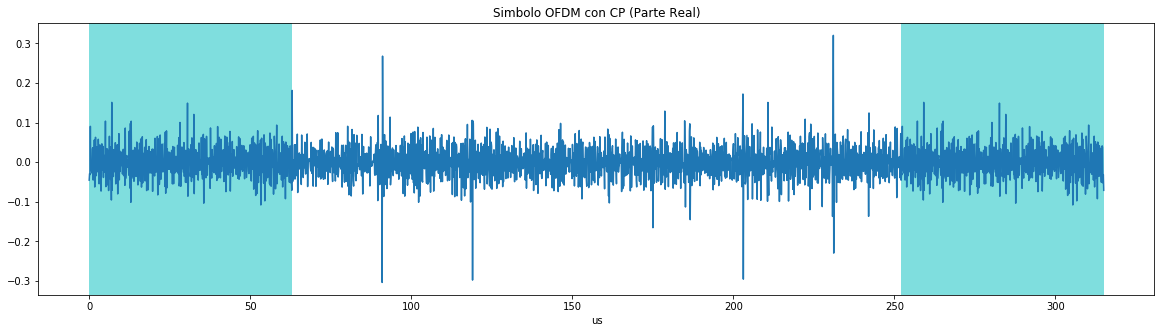

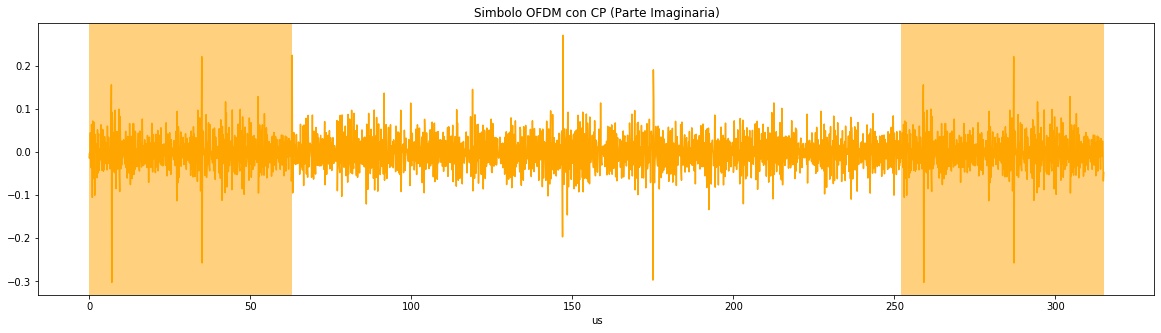

In [118]:
Fifft=2048/252 # 8,...MHz de frecuencia de muestreo de la ifft
Tifft=1/Fifft
t=np.linspace(0,Tifft*(Lifft+CP),Lifft+CP)

print("Duracion del simbolo activo {}us".format(t[-1]))
print("Duracion del simbolo util {}us".format(Tifft*Lifft))
print("Duracion de la guarda {}us".format(t[-1]-(Tifft*Lifft)))

plt.figure(figsize=(20,5))
plt.plot(t,OFDM_withCP.real)
plt.title("Simbolo OFDM con CP (Parte Real)")
plt.xlabel("us")
plt.axvspan(t[0],Tifft*(Lifft//4), facecolor='c', alpha=0.5)
plt.axvspan(Tifft*Lifft,t[-1], facecolor='c', alpha=0.5)

plt.figure(figsize=(20,5))
plt.plot(t,OFDM_withCP.imag,'orange')
plt.title("Simbolo OFDM con CP (Parte Imaginaria)")
plt.xlabel("us")
plt.axvspan(t[0],Tifft*(Lifft//4), facecolor='orange', alpha=0.5)
plt.axvspan(Tifft*Lifft,t[-1], facecolor='orange', alpha=0.5)

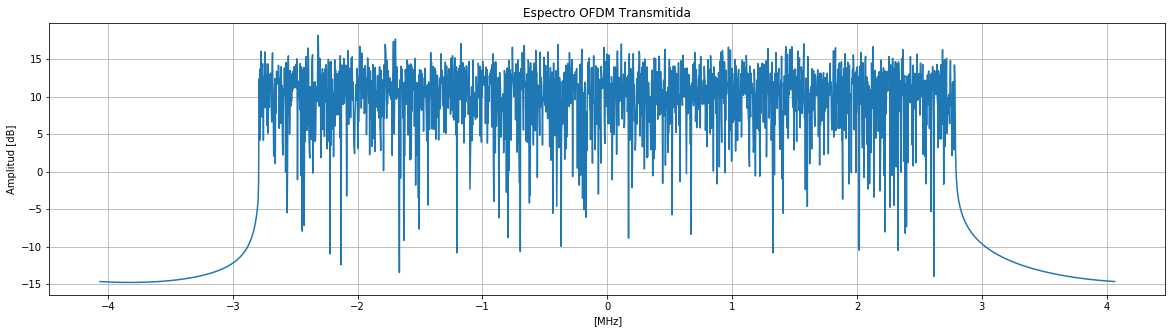

In [119]:
fcia=np.linspace((-(Fifft)/2),((Fifft)/2),Lifft+CP)
plt.figure(figsize=(20,5))
plt.plot(fcia,20*np.log10(np.abs(np.fft.fft(OFDM_withCP))))
plt.title("Espectro OFDM Transmitida")
plt.xlabel("[MHz]")
plt.ylabel("Amplitud [dB]")
plt.grid(True)


## PAR/PAPR

La relacion entre la potencia pico y la potencia media es de 31.15 veces, en dB es de 14.93 dB


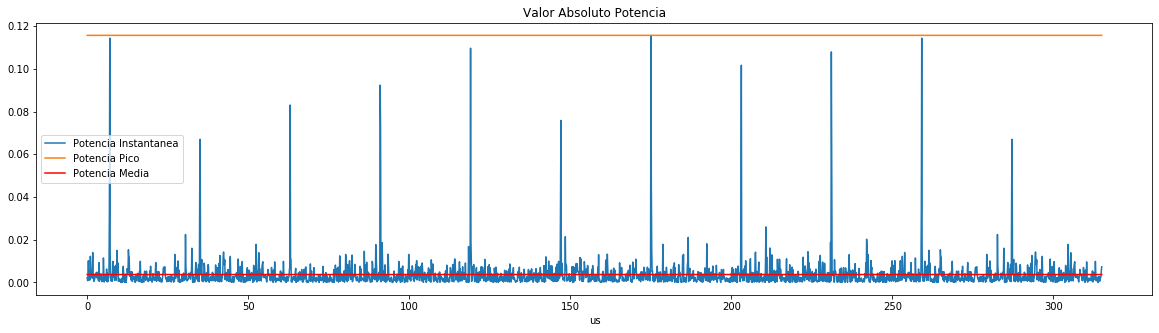

In [120]:
potencia_Simbolo=OFDM_withCP*np.conj(OFDM_withCP) #Asi se calcula la potencia compleja referida a 1  ohm
potencia_Simbolo=(potencia_Simbolo.real)

plt.figure(figsize=(20,5))
plt.plot(t,potencia_Simbolo,label='Potencia Instantanea')
plt.plot(t,np.ones(len(potencia_Simbolo))*np.max(potencia_Simbolo),label='Potencia Pico')
plt.plot(t,np.ones(len(potencia_Simbolo))*np.mean(potencia_Simbolo),'r',label='Potencia Media')
plt.title("Valor Absoluto Potencia")
plt.xlabel("us")
plt.legend()
PAR=np.max(potencia_Simbolo)/np.mean(potencia_Simbolo)
print("La relacion entre la potencia pico y la potencia media es de %.2f veces, en dB es de %.2f dB"%(PAR,10*np.log10(PAR)))

## CCDF (Complementary Cumulative Distribution Function)

/home/supremequeen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log10


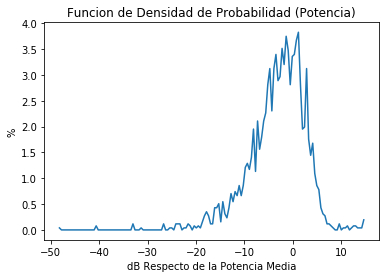

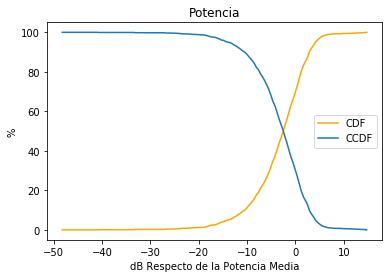

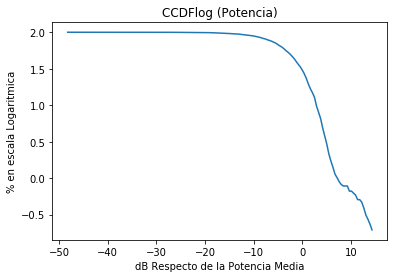

In [121]:
def CCDFdB(potencia):
    #PDF
    dB=10*np.log10(potencia)-10*np.log10(np.mean(potencia)) #dB sera respecto de la potencia media    
    h,b = np.histogram(dB, 150)
    b = b[:-1] + (b[1] - b[0])/2   # Los bins no estan centrados
                                   # Cada intervalo esta definido por 2 bins, donde empieza y donde termina
                                   # Con esto voy a determinar el centro de cada guarda
    plt.figure()
    plt.plot(b,(h/len(dB))*100)
    plt.title("Funcion de Densidad de Probabilidad (Potencia)")
    plt.xlabel("dB Respecto de la Potencia Media")
    plt.ylabel("%")
    #CDF y CCDF
    CDF = np.cumsum(h)/len(potencia)
    CCDF=1-CDF
    plt.figure()
    plt.plot(b,(CDF)*100,'orange',label='CDF')
    plt.plot(b,(CCDF)*100,label='CCDF')
    plt.title("Potencia")
    plt.xlabel("dB Respecto de la Potencia Media")
    plt.ylabel("%")
    plt.legend()
 
    CCDFlog=np.log10(CCDF*100)
    plt.figure()
    plt.plot(b,(CCDFlog))
    plt.title("CCDFlog (Potencia)")
    plt.xlabel("dB Respecto de la Potencia Media")
    plt.ylabel("% en escala Logaritmica")
    return CCDF*100
    
CCDF=CCDFdB(potencia_Simbolo)

## Canal de Transmision

/home/supremequeen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  after removing the cwd from sys.path.


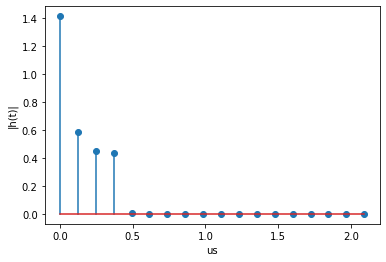

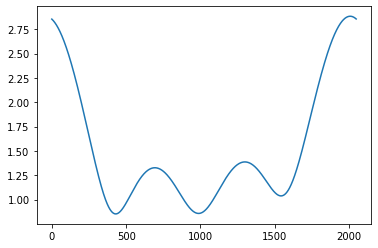

In [122]:
channelResponse = np.array([1+1j,0.5+0.3j,0.4+0.2j,0.39+0.19j,0.01,0,0,0,0,0,0,0,0,0,0,0,0,0])  # Respuesta al impulso del canal de comunicaciones
#channelResponse =np.array([1,0.3])
plt.figure()
plt.stem(t[0:len(channelResponse)],np.abs(channelResponse))
plt.xlabel('us')
plt.ylabel('|h(t)|')

channelResponse_Tiempo = np.fft.fft(channelResponse, Lifft)
plt.figure()
plt.plot(carriersTotales, abs(channelResponse_Tiempo))

SNRdB=35

RX Signal power: 0.0050
Noise power: 0.0000


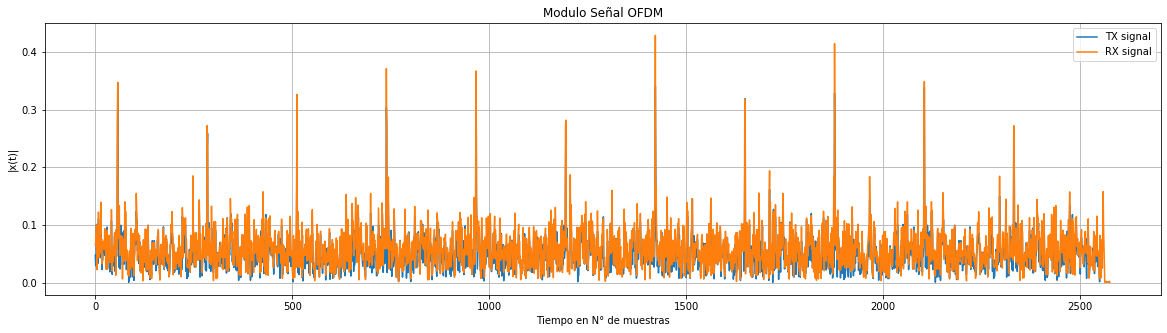

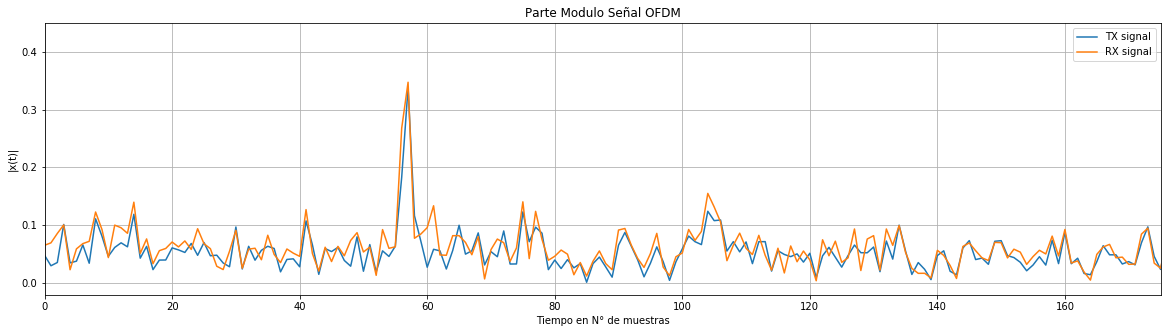

In [123]:
def channel(signal):
    convolved = np.convolve(signal, channelResponse)
    signal_power = np.mean(abs(convolved**2))
    sigma2 = signal_power * 10**(-SNRdB/10)  # Calcula la potencia de ruido en base al SNR
    print ("RX Signal power: %.4f" % signal_power)
    print ("Noise power: %.4f" %sigma2)
    # Genero el ruido a partir de la varianza obtenida
    noise = np.sqrt(sigma2/2) * (np.random.randn(*convolved.shape)+1j*np.random.randn(*convolved.shape))
    return convolved + noise

OFDM_TX = OFDM_withCP
OFDM_RX = channel(OFDM_TX)
plt.figure(figsize=(20,5))
plt.plot(abs(OFDM_TX), label='TX signal')
plt.plot(abs(OFDM_RX), label='RX signal')
plt.title("Modulo Señal OFDM")
plt.legend(fontsize=10)
plt.xlabel('Tiempo en N° de muestras')
plt.ylabel('|x(t)|')
plt.grid(True)

plt.figure(figsize=(20,5))
plt.plot(abs(OFDM_TX), label='TX signal')
plt.plot(abs(OFDM_RX), label='RX signal')
plt.title("Parte Modulo Señal OFDM")
plt.legend(fontsize=10)
plt.xlabel('Tiempo en N° de muestras')
plt.ylabel('|x(t)|')
plt.xlim([0,175])
plt.grid(True)

## Recepción 

In [124]:
def removeCP(signal):
    return signal[CP:(CP+Lifft)]
OFDM_RX_noCP = removeCP(OFDM_RX)

In [125]:
def DFT(OFDM_RX):
    return np.fft.fft(OFDM_RX)
OFDM_demod = DFT(OFDM_RX_noCP)

/home/supremequeen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  # This is added back by InteractiveShellApp.init_path()


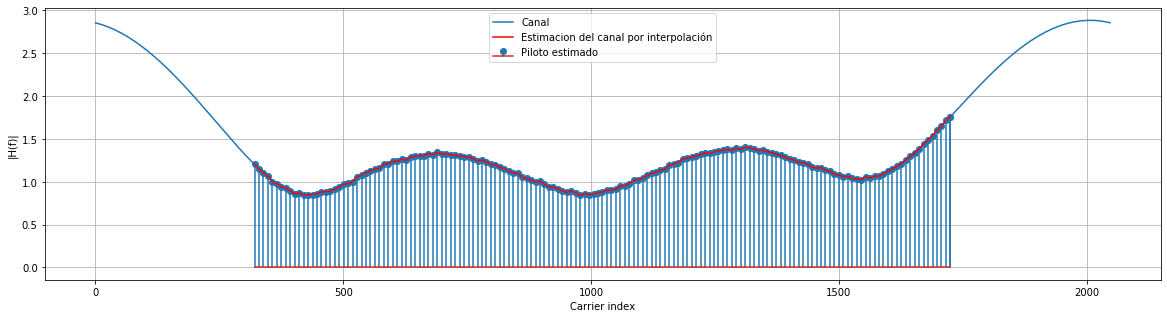

In [126]:
def channelEstimate(OFDM_demod):
    pilots = OFDM_demod[carriersPiloto+Lnull//2]  # Extraigo los pilotos de la senal recibida
    Hest_at_pilots = pilots / pilotValue  #Divido por el valor de los pilotos transmitidos
    Hest_abs = interpolate.interp1d(carriersPiloto+Lnull//2, abs(Hest_at_pilots), kind='linear')(carriersActivas+Lnull//2)
    Hest_phase = interpolate.interp1d(carriersPiloto+Lnull//2, np.angle(Hest_at_pilots), kind='linear')(carriersActivas+Lnull//2)
    Hest = Hest_abs * np.exp(1j*Hest_phase)
    
    plt.figure(figsize=(20,5))
    #plt.plot(carriersActivas, abs(channelResponse_Tiempo[Lnull//2:Lnull//2+L]), label='Canal')
    plt.plot(carriersTotales, abs(channelResponse_Tiempo), label='Canal')
    plt.stem(carriersPiloto+Lnull//2, abs(Hest_at_pilots), label='Piloto estimado')
    plt.plot(carriersActivas+Lnull//2, abs(Hest),'r', label='Estimacion del canal por interpolación')
    plt.grid(True)
    plt.xlabel('Carrier index')
    plt.ylabel('|H(f)|')
    plt.legend(fontsize=10)

    return Hest

Hest = channelEstimate(OFDM_demod)
OFDM_demod=OFDM_demod[Lnull//2:Lnull//2 + L] #Elimino las portadoras nulas recien ahora

In [127]:
def equalize(OFDM_demod, Hest):
    return OFDM_demod / Hest
OFDM_demod_ec = equalize(OFDM_demod, Hest)

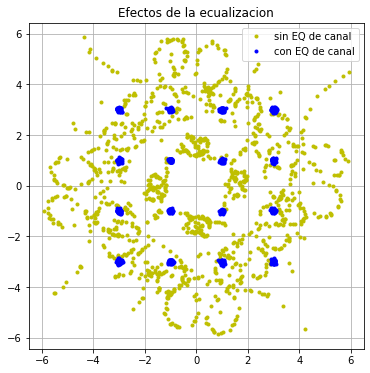

In [128]:
#Extraigo los datos (ignoro las portadoras)
def get_payload(simb_activos):
    return simb_activos[carriersDatos]

datos_RX_ec = get_payload(OFDM_demod_ec)
datos_RX_sinEc = get_payload(OFDM_demod)

plt.figure(figsize=(6,6))
plt.plot(datos_RX_sinEc.real, datos_RX_sinEc.imag, 'y.',label="sin EQ de canal")
plt.plot(datos_RX_ec.real, datos_RX_ec.imag, 'b.',label="con EQ de canal")
plt.title("Efectos de la ecualizacion")
plt.grid(True)
plt.legend(fontsize=10,loc='upper right')

In [129]:
def Demapping(RX):
    dists = abs(RX.reshape((-1,1)) - constelacion.reshape((1,-1))) # Calcula la distacia entre los puntos y la constelacion
    #Si quiero ver exactamente que hace esta linea de codigo:
    #OJO que reshape(-1,1) es distinto a reshape (1,-1)!!! https://stackoverflow.com/questions/18691084/what-does-1-mean-in-numpy-reshape
    #print(constelacion[:5].reshape(1,-1))
    #print(RX[:5].reshape(-1,1))
    #print(RX[:5].reshape(-1,1)-constelacion[:5].reshape(1,-1))
    const_index = dists.argmin(axis=1) # para cada punto de QAM, elijo en indice en la constelacion que pertenece al simbolo mas cercano 
    hardDecision = constelacion[const_index] # punto real de la constelacion
    return hardDecision # transformo la constelación en bits

hardDecision = Demapping(datos_RX_ec)

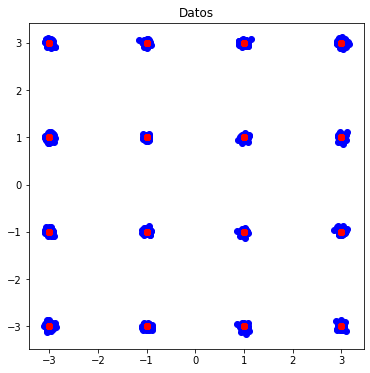

In [130]:
plt.figure(figsize=(6,6))
plt.title("Datos")
for qam, hard in zip(datos_RX_ec, hardDecision): #Me voy a fijar si el original y el "estimado" coinciden
    plt.plot([qam.real, hard.real], [qam.imag, hard.imag], 'b-o');
    plt.plot(hardDecision.real, hardDecision.imag, 'ro')

In [131]:
bits_demod=qamObj.demodulate(datos_RX_ec,'hard')
print ("Obtained Bit error rate: ", np.sum(abs(bits-bits_demod))/len(bits))

Obtained Bit error rate:  0.0


# Si resumo el procedimiento...

In [132]:
N_sym=30
frame=np.empty(0)

BW=6*(10**6)
modo=1
L=1404*(2**(modo-1))+1 
Ls=int((L-1)/13)
Lspil=12*(2**(modo-1))
Lsdat=Ls-Lsinf     #Portadoras datos

CP=Lifft//4

carriersActivas=np.arange(L)
carriersPiloto=carriersActivas[::int((L-1)/(Lspil*13))]
carriersPiloto = np.hstack([carriersPiloto, np.array([carriersActivas[-1]])]) 
carriersDatos = np.delete(carriersActivas, carriersPiloto)

Lifft=2**(10+modo) #Portadoras activas + nulas
Lnull=Lifft-L
carriersTotales=np.arange(Lifft)
Fifft=2048/252 # 8,...MHz de frecuencia de muestreo de la ifft
Tifft=1/Fifft

In [133]:
muData= 4 # bits per symbol data(i.e. 16QAM)
muPiloto= 4 # bits per symbol data(i.e. 16QAM)

bits_OFDMsimbolo= len(carriersDatos)*muData+len(carriersPiloto)*muPiloto  #Numero de bits transportados en un simbolo OFDM
bits_Data_OFDMsimbolo= len(carriersDatos)*muData  #Numero de bits de datos transportados en un simbolo OFDM

In [134]:
Mod_Obj= cp.modulation.QAMModem(2**muData)
pilotValue = (1+1j)*(((2**muPiloto))**0.5-1) # Valor conocido que se asignara a las portadoras

In [135]:
for sym in range(N_sym):
    bits = np.random.binomial(n=1, p=0.5, size=(bits_Data_OFDMsimbolo, ))
    MAP_Data= Mod_Obj.modulate(bits)
    OFDM_data = OFDM_symbol(MAP_Data)
    OFDM_time = IDFT(OFDM_data)
    OFDM_withCP = addCP(OFDM_time)
    frame=np.append(frame,OFDM_withCP,axis=0)

#frame=channel(frame)

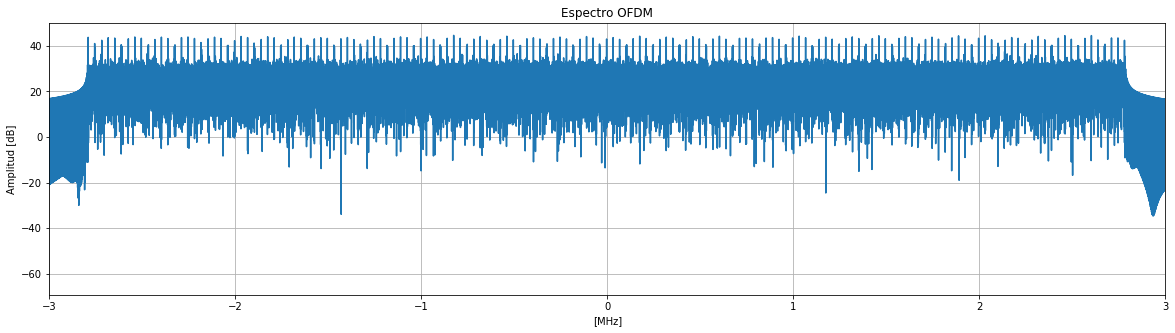

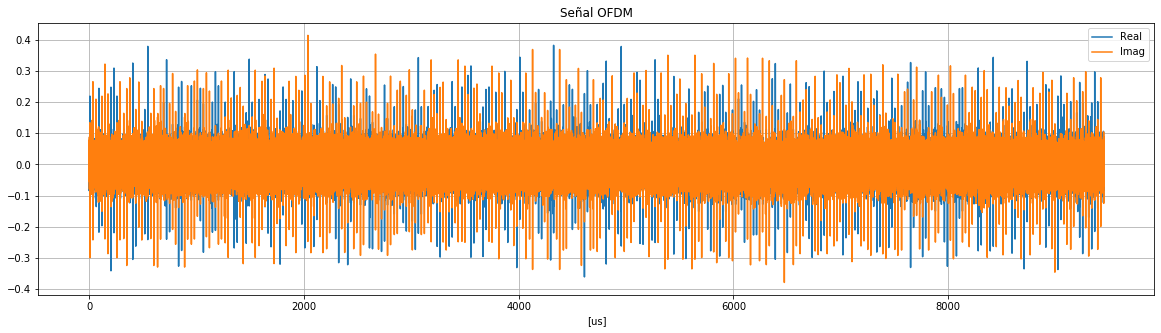

In [136]:
fcia=np.linspace((-(Fifft)/2),((Fifft)/2),len(frame))
t=np.linspace(0,Tifft*(Lifft+CP)*N_sym,len(frame))

plt.figure(figsize=(20,5))
plt.plot(fcia,20*np.log10(np.abs(np.fft.fft(frame))))
plt.title("Espectro OFDM")
plt.xlabel("[MHz]")
plt.ylabel("Amplitud [dB]")
plt.xlim([-3,3])
plt.grid(True)

plt.figure(figsize=(20,5))
plt.plot(t,frame.real,label='Real')
plt.plot(t,frame.imag,label='Imag')
plt.title("Señal OFDM")
plt.xlabel("[us]")
plt.legend()
plt.grid(True)